In [94]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_curve
from sklearn.model_selection import KFold

In [6]:
data_path = Path("Data/CreditScoring.csv")
full_data_path = Path.cwd().parents[1].joinpath(data_path)
df = pd.read_csv(full_data_path)

df.columns = df.columns.str.lower()

In [8]:
status_values = {
    1: 'ok',
    2: 'default',
    0: 'unk'
}

df.status = df.status.map(status_values)


home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'
}

df.home = df.home.map(home_values)

marital_values = {
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'separated',
    5: 'divorced',
    0: 'unk'
}

df.marital = df.marital.map(marital_values)

records_values = {
    1: 'no',
    2: 'yes',
    0: 'unk'
}

df.records = df.records.map(records_values)

job_values = {
    1: 'fixed',
    2: 'partime',
    3: 'freelance',
    4: 'others',
    0: 'unk'
}

df.job = df.job.map(job_values)

In [9]:
# Prepare the numerical variables:
for c in ['income', 'assets', 'debt']:
    df[c] = df[c].replace(to_replace=99999999, value=0)

In [10]:
# Remove clients with unknown default status
df = df[df.status != 'unk'].reset_index(drop=True)

In [11]:
# Create the target variable
df['default'] = (df.status == 'default').astype(int)
del df['status']

In [12]:
df.dtypes

seniority     int64
home         object
time          int64
age           int64
marital      object
records      object
job          object
expenses      int64
income        int64
assets        int64
debt          int64
amount        int64
price         int64
default       int32
dtype: object

In [13]:
df.columns

Index(['seniority', 'home', 'time', 'age', 'marital', 'records', 'job',
       'expenses', 'income', 'assets', 'debt', 'amount', 'price', 'default'],
      dtype='object')

In [25]:
categorical = ['home', 'marital', 'records', 'job']
numerical = ['seniority', 'time', 'age', 'expenses', 'income', 'assets', 'debt', 'amount', 'price']

### Execute the preparation code from the starter notebook
Split the dataset into 3 parts: train/validation/test with 60%/20%/20% distribution. Use train_test_split funciton for that with random_state=1

In [21]:
df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_train_full, test_size=0.2, random_state=1)

y_train = df_train.default.values
y_val = df_val.default.values

del df_train['default']
del df_val['default']

### Question 1
- For each numerical variable, use it as score and compute AUC with the "default" variable 
- Use the training dataset for that

If your AUC is < 0.5, invert this variable by putting "-" in front
(e.g. -df_train['expenses'])


AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

- seniority
- time
- income
- debt

ANSWER = seniority

In [44]:
for numerical_variable in numerical:
    single_variable_train = df_train[[numerical_variable]]
    single_variable_val = df_val[[numerical_variable]]
    
    model = LogisticRegression(solver='liblinear', random_state=1)
    model.fit(single_variable_train, y_train)
    y_pred = model.predict_proba(single_variable_val)[:, 1]
    auc_score = roc_auc_score(y_val, y_pred)
    
    if auc_score < .5:
        single_variable_train = -df_train[[numerical_variable]]
        single_variable_val = -df_val[[numerical_variable]]
        model = LogisticRegression(solver='liblinear', random_state=1)
        model.fit(single_variable_train, y_train)
        y_pred = model.predict_proba(single_variable_val)[:, 1]
        auc_score = roc_auc_score(y_val, y_pred)
        
    print(f"{numerical_variable}")
    print("roc auc score:\t", auc_score)
    print()

seniority
roc auc score:	 0.7011137511137511

time
roc auc score:	 0.5482773982773983

age
roc auc score:	 0.57002277002277

expenses
roc auc score:	 0.5059845559845559

income
roc auc score:	 0.6894861894861894

assets
roc auc score:	 0.6046777546777545

debt
roc auc score:	 0.511954261954262

amount
roc auc score:	 0.5732353232353232

price
roc auc score:	 0.45591525591525595



### Training the model
From now on, use these columns only:

```
['seniority', 'income', 'assets', 'records', 'job', 'home']
```

Apply one-hot-encoding using DictVectorizer and train the logistic regression with these parameters:

```
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```


In [47]:
train_columns = ['seniority', 'income', 'assets', 'records', 'job', 'home']
num_sub_cols = ['seniority', 'income', 'assets']
cat_sub_cols = ['records', 'job', 'home']

In [46]:
df[train_columns].dtypes

seniority     int64
income        int64
assets        int64
records      object
job          object
home         object
dtype: object

In [51]:
train_dict = df_train[cat_sub_cols + num_sub_cols].to_dict(orient='records')

dv = DictVectorizer(sparse=False)
dv.fit(train_dict)

X_train = dv.transform(train_dict)

In [52]:
model = LogisticRegression(solver='liblinear', random_state=1)
model.fit(X_train, y_train)

LogisticRegression(random_state=1, solver='liblinear')

In [53]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)
y_pred = model.predict_proba(X_val)[:, 1]

### Question 2
What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.512
- 0.612
- 0.712
- 0.812

In [56]:
auc_score = roc_auc_score(y_val, y_pred)
print(round(auc_score, 3))

0.826


### Question 3
Now let's compute precision and recall for our model.

- Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
- For each threshold, compute precision and recall
- Plot them
At which threshold precision and recall curves intersect?

- 0.2
- 0.4
- 0.6
- 0.8

ANSWER = .4

In [60]:
true_positive = ((y_pred >= 0.5) & (y_val == 1)).sum()
false_positive = ((y_pred >= 0.5) & (y_val == 0)).sum()
false_negative = ((y_pred < 0.5) & (y_val == 1)).sum()
true_negative = ((y_pred < 0.5) & (y_val == 0)).sum()

confusion_table = np.array(
     # predict neg    pos
    [[true_negative, false_positive], # actual neg
     [false_negative, true_positive]]) # actual pos

confusion_table

array([[478,  40],
       [108,  87]])

In [61]:
confusion_table / confusion_table.sum()

array([[0.67040673, 0.05610098],
       [0.15147265, 0.12201964]])

In [62]:
precision = true_positive / (true_positive + false_positive)
recall = true_positive / (true_positive + false_negative)
precision, recall

(0.6850393700787402, 0.4461538461538462)

In [63]:
confusion_table / confusion_table.sum()

array([[0.67040673, 0.05610098],
       [0.15147265, 0.12201964]])

In [64]:
precision = true_positive / (true_positive + false_positive)
recall = true_positive / (true_positive + false_negative)
precision, recall

(0.6850393700787402, 0.4461538461538462)

In [78]:
scores = []

thresholds = np.linspace(0, 1, 101)

for t in thresholds: #B
    tp = ((y_pred >= t) & (y_val == 1)).sum()
    fp = ((y_pred >= t) & (y_val == 0)).sum()
    fn = ((y_pred < t) & (y_val == 1)).sum()
    tn = ((y_pred < t) & (y_val == 0)).sum()
    scores.append((t, tp, fp, fn, tn))

df_scores = pd.DataFrame(scores)
df_scores.columns = ['threshold', 'tp', 'fp', 'fn', 'tn']

df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

df_scores['precision'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['recall'] = df_scores.tp / (df_scores.tp + df_scores.fn)

df_scores

,threshold,tp,fp,fn,tn,tpr,fpr,precision,recall
0,0.00,195,518,0,0,1.000000,1.000000,0.273492,1.000000
1,0.01,195,511,0,7,1.000000,0.986486,0.276204,1.000000
2,0.02,193,500,2,18,0.989744,0.965251,0.278499,0.989744
3,0.03,192,483,3,35,0.984615,0.932432,0.284444,0.984615
4,0.04,192,462,3,56,0.984615,0.891892,0.293578,0.984615
...,...,...,...,...,...,...,...,...,...
96,0.96,0,0,195,518,0.000000,0.000000,NaN,0.000000
97,0.97,0,0,195,518,0.000000,0.000000,NaN,0.000000
98,0.98,0,0,195,518,0.000000,0.000000,NaN,0.000000
99,0.99,0,0,195,518,0.000000,0.000000,NaN,0.000000


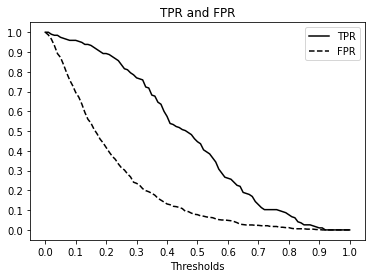

In [83]:
plt.figure(figsize=(6, 4))

plt.plot(df_scores.threshold, df_scores.tpr, color='black', linestyle='solid', label='TPR')
plt.plot(df_scores.threshold, df_scores.fpr, color='black', linestyle='dashed', label='FPR')
plt.legend()

plt.xticks(np.linspace(0, 1, 11))
plt.yticks(np.linspace(0, 1, 11))

plt.xlabel('Thresholds')
plt.title('TPR and FPR')

# plt.savefig('04_fpr_tpr_plot.svg')

plt.show()

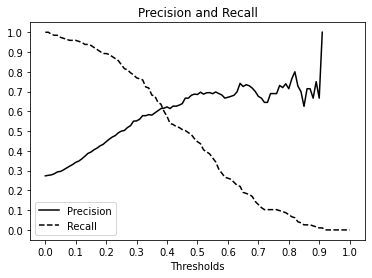

In [89]:
plt.figure(figsize=(6, 4))

plt.plot(df_scores.threshold, df_scores.precision, color='black', linestyle='solid', label='Precision')
plt.plot(df_scores.threshold, df_scores.recall, color='black', linestyle='dashed', label='Recall')
plt.legend()

plt.xticks(np.linspace(0, 1, 11))
plt.yticks(np.linspace(0, 1, 11))

plt.xlabel('Thresholds')
plt.title('Precision and Recall')

# plt.savefig('04_fpr_tpr_plot.svg')

plt.show()

### Question 4
Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

F1 = 2 * P * R / (P + R)

Where P is precision and R is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

- 0.1
- 0.3
- 0.5
- 0.7

ANSWER = .3

In [90]:
df_scores["f1_score"] = 2 * df_scores.precision * df_scores.recall / (df_scores.precision + df_scores.recall)

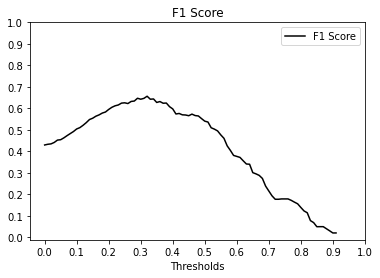

In [91]:
plt.figure(figsize=(6, 4))

plt.plot(df_scores.threshold, df_scores.f1_score, color='black', linestyle='solid', label='F1 Score')
#plt.plot(df_scores.threshold, df_scores.recall, color='black', linestyle='dashed', label='FPR')
plt.legend()

plt.xticks(np.linspace(0, 1, 11))
plt.yticks(np.linspace(0, 1, 11))

plt.xlabel('Thresholds')
plt.title('F1 Score')

# plt.savefig('04_fpr_tpr_plot.svg')

plt.show()

### Question 5
Use the KFold class from Scikit-Learn to evaluate our model on 5 different folds:

KFold(n_splits=5, shuffle=True, random_state=1)
- Iterate over different folds of df_full_train
- Split the data into train and validation
- Train the model on train with these parameters: LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
- Use AUC to evaluate the model on validation

How large is standard devidation of the AUC scores across different folds?

- 0.001
- 0.014
- 0.09
- 0.14

ANSWER = .014

In [92]:
def train(df, y):
    cat = df[cat_sub_cols + num_sub_cols].to_dict(orient='records')
    dv = DictVectorizer(sparse=False)
    dv.fit(cat)
    X = dv.transform(cat)
    model = LogisticRegression(solver='liblinear')
    model.fit(X, y)
    return dv, model


def predict(df, dv, model):
    cat = df[cat_sub_cols + num_sub_cols].to_dict(orient='records')
    X = dv.transform(cat)
    y_pred = model.predict_proba(X)[:, 1]
    return y_pred

In [95]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

aucs = []

for train_idx, val_idx in kfold.split(df_train_full[train_columns]):
    df_train = df_train_full.iloc[train_idx]
    y_train = df_train.default.values

    df_val = df_train_full.iloc[val_idx]
    y_val = df_val.default.values

    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)

    rocauc = roc_auc_score(y_val, y_pred)
    aucs.append(rocauc)

In [97]:
np.array(aucs).round(3).std()

0.013798550648528236

### Question 6

Now let's use 5-Fold cross-validation to find the best parameter C

- Iterate over the following C values: [0.01, 0.1, 1, 10]
- Initialize KFold with the same parameters as previously
- Use these parametes for the model: LogisticRegression(solver='liblinear', C=C, max_iter=1000)
- Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which C leads to the best mean score?

- 0.01
- 0.1
- 1
- 10

ANSWER = .5 OR 10
If you have ties, select the score with the lowest std. If you still have ties, select the smallest C

In [99]:
def train(df, y, C=1.0):
    cat = df[cat_sub_cols + num_sub_cols].to_dict(orient='records')
    dv = DictVectorizer(sparse=False)
    dv.fit(cat)
    X = dv.transform(cat)

    model = LogisticRegression(solver='liblinear', C=C)
    model.fit(X, y)

    return dv, model

In [100]:
nfolds = 5
kfold = KFold(n_splits=nfolds, shuffle=True, random_state=1)

for C in [0.001, 0.01, 0.1, 0.5, 1, 10]:
    aucs = []

    for train_idx, val_idx in kfold.split(df_train_full[train_columns]):
        df_train = df_train_full.iloc[train_idx]
        df_val = df_train_full.iloc[val_idx]

        y_train = df_train.default.values
        y_val = df_val.default.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)
        
        auc = roc_auc_score(y_val, y_pred)
        aucs.append(auc)

    print('C=%s, auc = %0.3f ± %0.3f' % (C, np.mean(aucs), np.std(aucs)))

C=0.001, auc = 0.767 ± 0.007
C=0.01, auc = 0.809 ± 0.013
C=0.1, auc = 0.812 ± 0.013
C=0.5, auc = 0.814 ± 0.015
C=1, auc = 0.812 ± 0.014
C=10, auc = 0.814 ± 0.015


In [102]:
y_train = df_train_full.default.values
y_test = df_test.default.values

dv, model = train(df_train_full[train_columns], y_train, C=0.5)
y_pred = predict(df_test, dv, model)

auc = roc_auc_score(y_test, y_pred)
print('auc = %.3f' % auc)

auc = 0.776
